# Artificial Intelligence II: Project 3
### Sentiment Classification using bidirectional stacked RNNs with LSTM/GRU cells
> Fall Semester 2022-2023

> Stylianos Oikonomou | 1115201500243

## Import Libraries

In [ ]:
%reset -f

In [ ]:
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
import random
import os

# Neural Network
import torch
import torch.nn as nn
import copy

# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score

# Stopwords
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

# Plotting / Results
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

# General
pd.set_option('max_colwidth', 10000)

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Reviews


In [ ]:
# Google Drive file ID from the shared link
file_id = '17K9rHy6iajoUW_IKDBwKE2LwajZzu1hV'
# Download URL for the file
download_url = f'https://drive.google.com/uc?id={file_id}'
# Fetch the content of the file
response = requests.get(download_url).content

In [ ]:
# Read the content into a pandas DataFrame
dataFrames = pd.read_csv(io.StringIO(response.decode('utf-8')), sep = '\t')
# Drop the "url" column from the dataFrame
dataFrames = dataFrames.drop(["url"], axis=1)
# Change the column order for better readability
dataFrames = dataFrames.loc[:, ["review", "rating"]]

review_count = dataFrames.shape[0]

In [ ]:
# Check if there are any Null fields in the data
# dataFrames.isnull().sum()

In [ ]:
# dataFrames.head()

## Download GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

## Transform GloVe embeddings to Word2Vec format

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.50d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 50)

## Create GloVe embeddings Dictionary

In [ ]:
with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

dict_word_count = int(w2v[0].split()[0])
feature_count = int(w2v[0].split()[1])

w2v_dict = {}

for word_vector_pair in w2v[1:]:
    word_vector_pair = word_vector_pair.split()

    word = word_vector_pair[0]
    vector = word_vector_pair[1:]

    w2v_dict[word] = list(map(float, vector))

## Preprocessing

In [ ]:
reviews = dataFrames.drop(["rating"], axis=1)
ratings = dataFrames.drop(["review"], axis=1)

Classify ratings

In [ ]:
def classifyRating(rating) :
  if rating >= 7 :
    return 1
  else :
    return 0

In [ ]:
classified_ratings = ratings.applymap(classifyRating)

Clean up reviews

In [ ]:
def cleanReview(review):
  review = re.sub(r'<[ a-z/]*>', ' ', review)                                   # Remove left-over HTML Tags
  # review = re.sub(r'[a-zA-Z0-9]*[0-9][a-zA-Z0-9]*', ' ', review)                # Remove numbers
  review = re.sub(r'[^`\'a-zA-Z0-9]', ' ', review)                              # Remove all non letter/ number characters
  review = re.sub(r"([a-zA-Z])(`|\')s", r"\1", review)                          # Remove the 's or `s suffix that follows a letter
                                                                                # ex. John's -> John ex. 90's -> 90's
  # review = re.sub(r'( [\'`]|[\'`] |`s |\'s )', ' ', review)                     # Clean apostrophe
  review = re.sub(r'\s+', ' ', review)                                          # Remove multiple white-spaces
  review = review.casefold()                                                    # Turn all letters to lower case
  review = [word for word in review.split() if word not in (stop)]              # Remove stop words
  return review

In [ ]:
cleaned_reviews = reviews.applymap(cleanReview)

In [ ]:
example = 15
# Before clean-up
print('Before :', reviews.iloc[example].to_string(index=False), end='\n\n')
# After clean-up
print('After  :', cleaned_reviews.iloc[example].to_string(index=False))

Before : ****Excellent<br /><br />***Good<br /><br />**Fair<br /><br />*Poor<br /><br />`Go Ahead, make my Day!' <br /><br />The fourth picture in the series is directed by Eastwood himself (Who was rumored of directing most of Magnum Force) and he brings back the violent society from the first two films. However, the film still lacks impact and believability. This film was released in the early `80s, the time of Regan and the young republicans. The premise of a raped woman taking vengeance on her rapist doesn't appeal to this time frame. This plot would have been better for the Enforcer, which actually would have made it a good movie. What Sudden Impact needed was a plot like in Wall Street but with Dirty Harry in the middle. <br /><br />RATING: 3 STARS

After  : [excellent, good, fair, poor, `go, ahead, make, day, ', fourth, picture, series, directed, eastwood, rumored, directing, magnum, force, brings, back, violent, society, first, two, films, however, film, still, lacks, impact, b

In [ ]:
# max_word_count = -np.inf
# min_word_count = np.inf
# mean_word_count = 0
# for index, row in cleaned_reviews.iterrows():
#   review_length = len(row['review'])
#   mean_word_count = mean_word_count + review_length
#   if review_length > max_word_count :
#     max_word_count = len(row['review'])
#   if review_length < min_word_count :
#     min_word_count = len(row['review'])
# mean_word_count = int(mean_word_count / cleaned_reviews.shape[0])
# print(f'Maximum words: {max_word_count}')
# print(f'Minimum words: {min_word_count}')
# print(f'Mean words   : {mean_word_count}')

Create input

In [ ]:
review_word_count = 80

list_reviews = cleaned_reviews['review'].values.tolist()

review_embeddings = []
for rev in list_reviews :
  for i in range(review_word_count) :
    if i < len(rev) :
      if rev[i] in w2v_dict:
        review_embeddings += w2v_dict[rev[i]]
      else :
        review_embeddings += [0] * feature_count
    else :
      review_embeddings += [0] * feature_count

In [ ]:
tensor_embeddings = torch.as_tensor(review_embeddings)
tensor_embeddings = tensor_embeddings.reshape(review_count, review_word_count, feature_count)

print(tensor_embeddings.size())

torch.Size([45008, 80, 50])


Let's examine our data

In [ ]:
example = 0
print(f'Review {example} : {cleaned_reviews.iloc[example].to_string(index=False)}')
print()
print(tensor_embeddings[example].shape)
print(tensor_embeddings[example])

Review 0 : [thought, quiet, good, movie, fun, watch, liked, best, 'outtakes', end, movie, great]

torch.Size([80, 50])
tensor([[ 0.4276, -0.1147,  0.0105,  ..., -0.0345, -0.0413,  0.2594],
        [ 0.4259,  0.3922, -0.8554,  ..., -0.6300, -0.2020,  0.3550],
        [-0.3559,  0.5213, -0.6107,  ...,  0.2721,  0.3131,  0.9277],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [ ]:
word = 0
print(f'word      : \'{cleaned_reviews.iloc[example][0][word]}\'')
print(f'embedding : {w2v_dict[cleaned_reviews.iloc[example][0][word]]}')

word      : 'thought'
embedding : [0.42762, -0.11469, 0.010506, -0.54662, 0.89055, 0.19263, -0.65374, 0.087461, -0.6983, 0.2802, 0.17176, 0.31886, -0.46253, -0.13414, 0.6207, 0.33603, 0.47793, -0.046861, -0.45179, -0.32765, -0.73017, 0.41449, 0.56783, 0.03801, 1.014, -1.885, -0.94402, 0.065002, 0.54992, -0.46939, 2.7234, -0.14071, -0.078016, -0.81424, -0.066414, -0.42336, 0.0078978, 0.40758, 0.21245, 0.1015, -0.37205, 0.018199, -0.081173, 0.76924, 0.30367, 0.051222, -0.23856, -0.034535, -0.041267, 0.2594]


In [ ]:
# Clean up some unnecessary variables
del dataFrames
del w2v, w2v_dict
del reviews, cleaned_reviews
del ratings
del stop, stopwords
del list_reviews, review_embeddings

## Split sets

In [ ]:
# x = tensor_embeddings
y = torch.tensor(classified_ratings.values, dtype=torch.float)
y = y.reshape(review_count)

print(f"x shape: {tensor_embeddings.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([45008, 80, 50])
y shape: torch.Size([45008])


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(tensor_embeddings, y, train_size=0.8, random_state=69)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

x_train shape: torch.Size([36006, 80, 50])
y_train shape: torch.Size([36006])
x_valid shape: torch.Size([9002, 80, 50])
y_valid shape: torch.Size([9002])


## Create a Neural Network

In [ ]:
class RNN(nn.Module):
    """
      Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        cells = {
        "RNN"     : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        self.cell_type = cell_type
        self.rnn = cells[cell_type](    # Pick the specific model
            input_size=input_size,      # Number of features for each time step
            hidden_size=hidden_size,    # rnn hidden units
            num_layers=num_layers,
            batch_first=True,           # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional=True
        )

        self.out = nn.Linear(2*hidden_size, output_size) # Feed forward network

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)

        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

Choose hyperparameters and set-up RNN

In [ ]:
input_size = feature_count
hidden_size = 64
num_layers = 2
output_size = 1
cell_type = 'LSTM'
net = RNN(cell_type, input_size, hidden_size, num_layers, output_size)
print(net)

EPOCH = 2
LR = 0.01
batchSize = 64

optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.BCEWithLogitsLoss()
sigm = nn.Sigmoid()

RNN(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, bidirectional=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


Initialize dataloader

In [ ]:
train_dataset    = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)

# for batch_idx, (data, target) in enumerate(train_dataloader):
#   if batch_idx == 0:
#     print(data.shape, target.shape)
#     break

## Train and test the model

Epoch:  0 | train loss: 0.6903 | test accuracy: 0.50
Epoch:  0 | train loss: 0.6836 | test accuracy: 0.55
Epoch:  0 | train loss: 0.7202 | test accuracy: 0.53
Epoch:  0 | train loss: 0.6853 | test accuracy: 0.53
Epoch:  0 | train loss: 0.6793 | test accuracy: 0.54
Epoch:  0 | train loss: 0.6124 | test accuracy: 0.73
Epoch:  0 | train loss: 0.3648 | test accuracy: 0.79
Epoch:  0 | train loss: 0.4211 | test accuracy: 0.79
Epoch:  0 | train loss: 0.3329 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4795 | test accuracy: 0.80
Epoch:  0 | train loss: 0.3333 | test accuracy: 0.81
Epoch:  0 | train loss: 0.4976 | test accuracy: 0.81
Epoch:  1 | train loss: 0.5273 | test accuracy: 0.81
Epoch:  1 | train loss: 0.3293 | test accuracy: 0.81
Epoch:  1 | train loss: 0.4458 | test accuracy: 0.81
Epoch:  1 | train loss: 0.5847 | test accuracy: 0.81
Epoch:  1 | train loss: 0.4650 | test accuracy: 0.79
Epoch:  1 | train loss: 0.4614 | test accuracy: 0.79
Epoch:  1 | train loss: 0.3635 | test accuracy

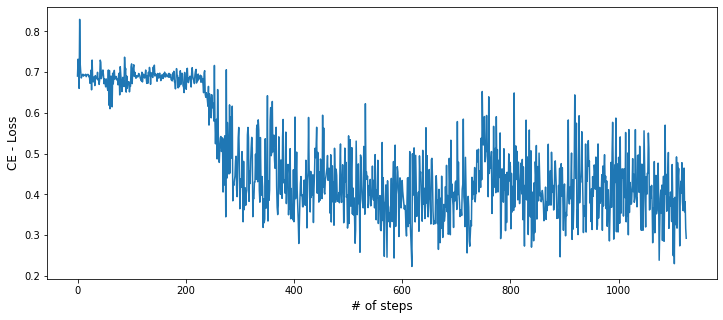

In [ ]:
# Start train mode
net.train()

# Accumulate losses
losses = []

# Count the number of batches given to the model
step_count = 0

# Evaluate the progress every # batches
print_every = 50

# Iterate over the whole dataset for one epoch
for epoch in range(EPOCH):

    # Generate batch data
    for step, (b_x, b_y) in enumerate(train_dataloader):

        # clear gradients for this training step
        optimizer.zero_grad()

        output = net(b_x)

        loss = loss_func(output.reshape(len(b_x)), b_y)

        # For visualization
        losses.append(loss.item())
        step_count += 1

        # backpropagation - compute gradients
        loss.backward()

        # apply gradients
        optimizer.step()

        # evaluate every N batches
        if step % print_every == 0:

            # Do not calculate gradients
            with torch.no_grad():

                # Faster inference
                net.eval()

                test_output = net(x_valid)

                # Get predicted class
                pred_y = sigm(test_output.reshape(len(test_output)))
                # Classify test predictions
                for i in range(len(pred_y)) :
                  if pred_y[i] < 0.5 :
                    pred_y[i] = 0
                  else :
                    pred_y[i] = 1

                # Calculate accuracy
                accuracy = (pred_y == y_valid).sum().item() / float(len(y_valid))
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)

            # Return to training mode
            net.train()

# Plot results
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()